Total de requisições: 5475
 % de requisições processadas: 100.0% (5475 processadas)
 % de arcos usados: 41.0958904109589%
 Largura de banda usada: 14.872000000000455
 Custo gasto: 0.2927071999999779

Total de requisições: 5684
 % de requisições processadas: 100.0% (5684 processadas)
 % de arcos usados: 44.44444444444444%
 Largura de banda usada: 15.47300000000053
 Custo gasto: 0.3074731999999768

Total de requisições: 5715
 % de requisições processadas: 100.0% (5715 processadas)
 % de arcos usados: 38.88888888888889%
 Largura de banda usada: 15.732000000000546
 Custo gasto: 0.3153759999999739

Total de requisições: 12961
 % de requisições processadas: 99.86112182701952% (12943 processadas)
 % de arcos usados: 44.72573839662447%
 Largura de banda usada: 36.751000000000786
 Custo gasto: 1.0998915999998997

Total de requisições: 12974
 % de requisições processadas: 99.91521504547556% (12963 processadas)
 % de arcos usados: 46.186440677966104%
 Largura de banda usada: 36.7570000000008
 Cus

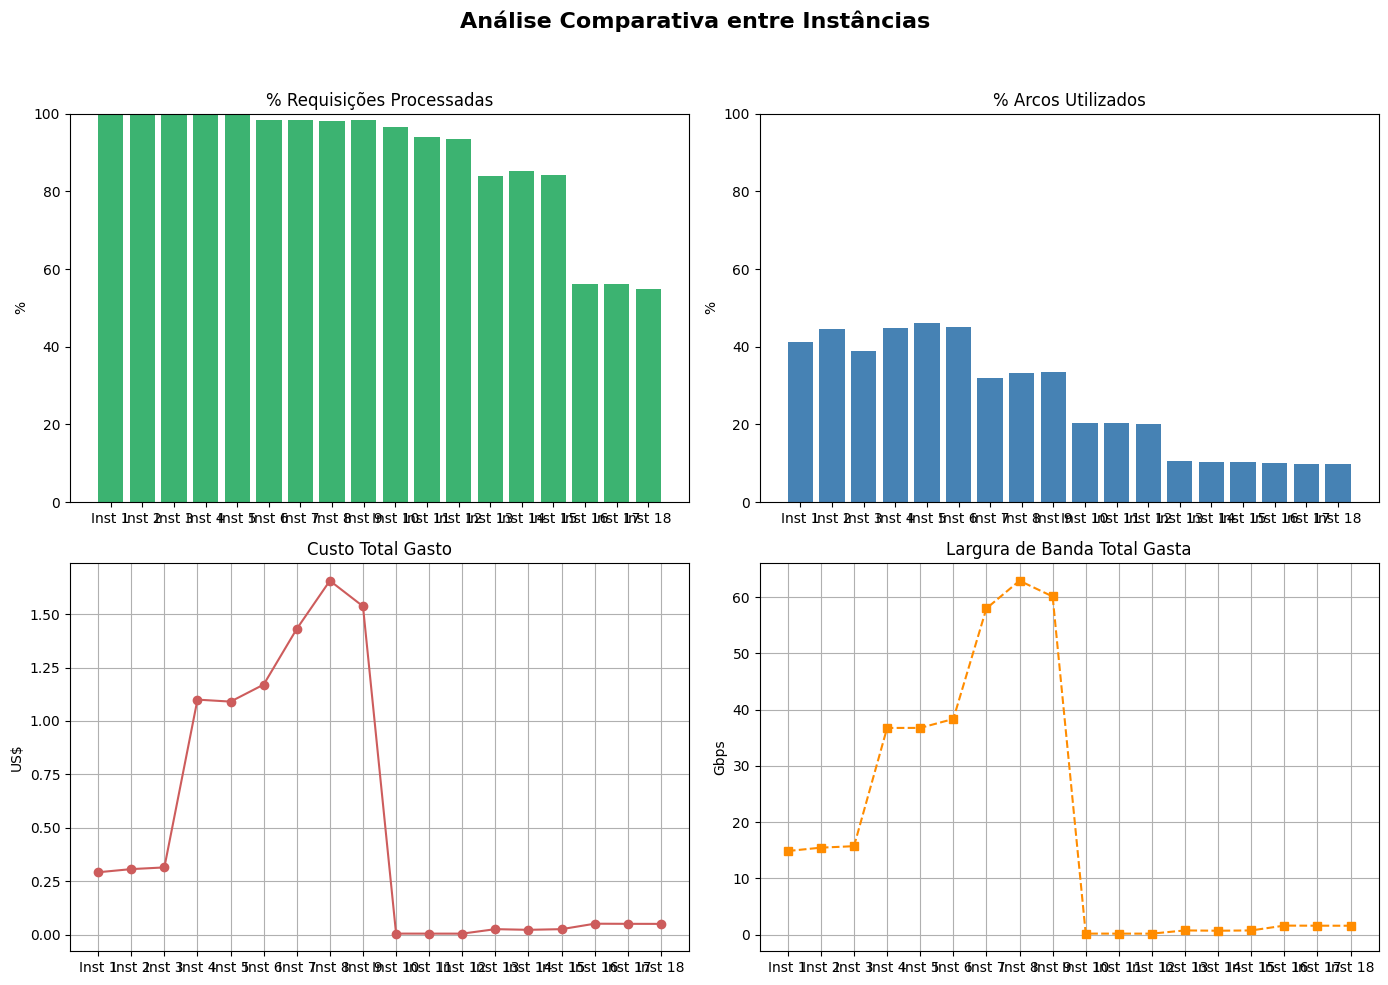

In [1]:
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

# CLASSE NETWORKNODE - Define um objeto "Nó" com características mais gerais
class NetworkNode:
    def __init__(self, ID, latitude, longitude):
        self.ID = ID
        self.latitude = latitude
        self.longitude = longitude

    def __repr__(self):
        return f"{self.__class__.__name__}({self.ID})"

    def __hash__(self):
        return hash(self.ID)

    def __eq__(self, other):
        return (self.ID == other.ID) and (type(self) is type(other))

# CLASSE FOGCLOUDNODE - Especifica um tipo de "Nó" em "Nó Fog" ou "Nó Cloud"
class FogCloudNode(NetworkNode):
    def __init__(self, ID, longitude, latitude, processing_capacity, memory_capacity, cost, model):
        super().__init__(ID, latitude, longitude)
        self.model = model
        self.processing_capacity = processing_capacity
        self.memory_capacity = memory_capacity
        self.cost = cost
        self.requisicoes = 0

# CLASSE FOGNODE - Especifica um "Nó Fog"
# Compartilha todas as características da classe pai
class FogNode(FogCloudNode):
    pass

# CLASSE CLOUDNODE - Especifica um "Nó Cloud"
# Compartilha todas as características da classe pai
class CloudNode(FogCloudNode):
    pass

# CLASSE SENSOR - Especifica um tipo de "Nó" em "nó Sensor"
class Sensor(NetworkNode):
    def __init__(self, ID, longitude, latitude, services):
        super().__init__(ID, latitude, longitude)
        self.services = services

# CLASSE ARESTA - Define um objeto para representar os arcos/arestas do grafo do problema
# Foi necessária a criação desse tipo de objeto devido aos seus múltiplos atributos
class Aresta:
    def __init__(self, u, v, largura_banda, custo, tempo):
        self.u = u
        self.v = v
        self.largura_banda = largura_banda
        self.custo = custo
        self.tempo = tempo
        self.quantidade_uso = 0

    def __repr__(self):
        return f"{self.__class__.__name__}({self.u}, {self.v})"

# CLASSE GRAFO - Define um objeto para representar o grafo do problema
class Grafo:
    def __init__(self):
        self.adj = {}  # Lista de Adjacências
        self.adj_ = {} # Lista de Arestas
        self.n_vertices = 0
        self.n_arestas = 0

    def add_vertice(self, noh):
        if noh not in self.adj:
            self.adj[noh] = []
            self.n_vertices += 1

    def add_aresta(self, u, v, largura_banda, custo, dist_H):
        self.add_vertice(u)
        self.add_vertice(v)
        # Em uma aresta, o atributo tempo significa o tempo de propagação dos dados nessa aresta
        # O tempo é definido como o tempo de atraso (numero de bits/velocidade de transmissão) somado ao tempo de propagação (distância Harvesine/velocidade de propagação)
            # O tempo de atraso para cada tipo de requisição, para a tecnologia 4G, é:
                # waste: 0.0000296
                # camera: 0.0012
                # air: 0.0000744
            # Média aritmética: 0.0004346
        tempo = 0.001 + float(dist_H)/(2*10**8)
        self.adj[u].append((v, largura_banda, custo, tempo))
        aresta = Aresta(u, v, largura_banda, custo, tempo)
        #aresta.largura_banda = float(largura_banda)
        self.adj_[f"({u},{v})"] = aresta
        self.n_arestas += 1

# FUNÇÃO FLOYD-WARSHALL - Função para calcular todos os caminhos do grafo, considerando o tempo como peso
# dist[u][v] - "Qual o tempo gasto para chegar em v no caminho que parte de u?"
# prev[u][v] - "Qual o nó anterior ao v no caminho que parte de u?"
def floyd_warshall(grafo):
    dist = {u: {v: float('inf') for v in grafo.adj.keys()} for u in grafo.adj.keys()}
    prev = {u: {v: None for v in grafo.adj.keys()} for u in grafo.adj.keys()}

    for u in grafo.adj.keys():
        dist[u][u] = 0
        for v, _, _, t in grafo.adj[u]:
            dist[u][v] = t
            prev[u][v] = u

    for k in grafo.adj.keys():
        for i in grafo.adj.keys():
            for j in grafo.adj.keys():
                if dist[i][j] > dist[i][k] + dist[k][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
                    prev[i][j] = prev[k][j]
    return dist, prev

# FUNÇÃO RECONSTRUIR CAMINHO
# Dada uma origem e um destino, a função utiliza a estrutura prev para reconstruir o caminho desde o destino até a origem
def reconstruir_caminho(prev, origem, destino):
    caminho = []
    atual = destino
    while atual is not None:
        caminho.append(atual)
        atual = prev[origem][atual]
    caminho.reverse()
    return caminho

# FUNÇÃO PROCESSAR CAMINHO
# Dado um caminho no grafo e uma requisição, essa função tenta alocar a requisição em algum nó Fog do caminho
def processar_caminho(caminho, requisicao, instante, temporal_arestas, dist):
    arcos = []
    band_tot = 0
    custo = 0
    selecionado = None
    tempo = 0
    motivo= f"No caminho {caminho}: "
    # Percorre o caminho por indices
    for i in range(len(caminho)-1):
        vertice_atual = caminho[i]
        vizinho = caminho[i+1]
        gasto_req = requisicao[2]/(10**9)
        tempo += dist[vertice_atual][vizinho]
        if (gasto_req <= grafo.adj_[f"({vertice_atual},{vizinho})"].largura_banda):
          if(tempo <= requisicao[3]):
            selecionado = vizinho
            arcos.append(f"({vertice_atual},{selecionado})")
            band_tot += gasto_req
            custo += gasto_req*grafo.adj_[f"({vertice_atual},{selecionado})"].custo
          else:
            motivo += f"Requisição estourou o tempo de vida em {vizinho}"
        else:
            motivo += f"Requisição estourou a largura de banda indo de {vertice_atual} para {vizinho}"

        # Se não encontrou vizinho válido
        if selecionado is None:
            return selecionado, False, arcos, band_tot, custo, motivo

        # Testa se o vizinho selecionado é apto para processar a requisicao, com base na capacidade de processamento e de memória do Nó Fog
        if(requisicao[0] <= selecionado.processing_capacity):
            if(requisicao[1] <= selecionado.memory_capacity):
                selecionado.processing_capacity -= requisicao[0]
                selecionado.memory_capacity -= requisicao[1]
                selecionado.requisicoes += 1
                return selecionado, True, arcos, band_tot, custo, motivo
    motivo += "Requisicao percorreu todo o caminho e não foi processada"
    return selecionado, False, arcos, band_tot, custo, motivo

# FUNÇÃO MAIN
# Chamada para cada instância gerada
# index - índice das instâncias e também dos arquivos de log e mapa
    # Facilita a correspondência entre os arquivos
def main(index):
    with open(f"{index}.txt", "r", encoding="utf-8") as f:

        # Primeiras 7 linhas do arquivo de instância ignoradas
        for i in range(7):
            f.readline()

        # sensors X
        linha = f.readline().strip()
        num_sensores = int(linha.split()[1])

        # fog_nodes X
        linha = f.readline().strip()
        num_fog = int(linha.split()[1])

        # cloud_nodes X
        linha = f.readline().strip()
        num_cloud = int(linha.split()[1])

        # services X
        linha = f.readline().strip()
        num_servicos = int(linha.split()[1])

        # Ignora as próximas duas linhas
        f.readline() # #end_instance_info
        f.readline() # #begin_sensors

        # Lê os Nós Sensores
        sensores = []
        for i in range(num_sensores):
            linha = f.readline().strip().split()
            # Sensores -> index | longitude | latitude | services
            sensor = Sensor(linha[0], linha[1], linha[2], linha[3::])
            sensores.append(sensor)
            grafo.add_vertice(sensor)

        # Ignora as próximas duas linhas
        f.readline() # #end_sensors
        f.readline() # #begin_fog

        # Lê os Nós Fog
        fogs = []
        for i in range(num_fog):
            linha = f.readline().strip().split()
            # Fog -> index | longitude | latitude | processing capacity | memory capacity | cost | model
            fog = FogNode(linha[0], float(linha[1]), float(linha[2]), float(linha[3]), float(linha[4]), float(linha[5]), linha[6])
            fogs.append(fog)
            grafo.add_vertice(fog)

        # Lê as arestas entre Nós Fog
        num_fogfog = int(f.readline().strip())
        for i in range(num_fogfog):
            linha = f.readline().strip().split()
            # Arestas -> node i | node j | bandwidth i-j | bandwidth cost (US$/Gbps) | haversine distance i-j
            grafo.add_aresta(fogs[int(linha[1])], fogs[int(linha[2])], float(linha[3]), float(linha[4]), float(linha[5]))

        # Ignora as próximas duas linhas
        f.readline() # #end_fog
        f.readline() # #begin_reach_fog_nodes

        # Lê as arestas entre Nós Sensores e Nós Fog
        linha = f.readline().strip()
        while linha != "#end_reach_fog_nodes":
            linha = linha.split()
            # Arestas -> node i | node j | bandwidth i-j | bandwidth cost (US$/Gbps) | haversine distance i-j
            grafo.add_aresta(sensores[int(linha[1])], fogs[int(linha[2])], float(linha[3]), float(linha[4]), float(linha[5]))
            linha = f.readline().strip()

        # Ignora a próxima linha
        f.readline() # #begin_cloud

        # Lê os Nós Cloud
        clouds = []
        for i in range(num_cloud):
            linha = f.readline().strip().split()
            # Cloud -> index | longitude | latitude | processing capacity | memory capacity | cost | model
            cloud = CloudNode(linha[0], float(linha[1]), float(linha[2]), float(linha[3]), float(linha[4]), float(linha[5]), linha[6])
            clouds.append(cloud)

        # Lê as arestas entre Nós Fog e Nós Cloud
        num_fogcloud = int(f.readline().strip())
        for i in range(num_fogcloud):
            linha = f.readline().strip().split()
            # Arestas -> node i | node j | bandwidth i-j | bandwidth cost (US$/Gbps) | haversine distance i-j
            grafo.add_aresta(fogs[int(linha[1])], clouds[int(linha[2])], float(linha[3]), float(linha[4]), float(linha[5]))

        # Ignora as próximas duas linhas
        f.readline() # #end_cloud
        f.readline() # #begin_service

        # Lê os serviços
        servicos = {}
        for i in range(num_servicos):
            linha =  f.readline().strip().split()
            # ID: [processing_demand, memory_demand, number_of_bits, lifetime]
            servicos[linha[0]] = [float(linha[1]), float(linha[2]), int(linha[3]), int(linha[4])]

        # Ignora as próximas duas linhas
        f.readline() # #end_services
        f.readline() # #begin_requests

        ## PARTE 2 - Leitura das requests

        # Estrutura para controlar a disponibilidade de Processamento e Memória para os nós fog
        # i: (v,p,m) - Ao instante "i", uma quantidade "p" de processamento e "m" de memória volta a estar disponível no nó "v"
        temporal = {i: [] for i in range(1, 1001)}

        # Estrutura para controlar a disponibilidade de largura de banda para as arestas
        # i: (aresta, band) - Ao instante i, uma quantidade "band" de largura de banda volta a estar disponível na aresta "aresta"
        temporal_arestas = {i: [] for i in range(1, 1002)}

        linha = f.readline().strip() # ##time_instant_1
        tot_req = 0
        quant_req = 0
        set_arcos = []
        quant_band = 0
        quant_custo = 0

        # Chama a função Floyd-Warshall para já deixar pré-processado todos os caminhos do grafo
        dist, prev = floyd_warshall(grafo)

        # Abre o arquivo log pela primeira vez e adiciona ium cabeçalho
        with open(f"log_{index}.txt", "w", encoding="utf-8") as l:
            l.write(f"COMECANDO LOG DA INSTÂNCIA {index}.txt\n")

        # Começa a ler as requisições
        while linha != "#end_requests":
            instante = int(linha.split("_")[2]) # Lê e armazena o instante

            # Faz as atualizações no grafo
            for (v, p, m) in temporal[instante]:
                v.processing_capacity += p
                v.memory_capacity += m
            for aresta, band in temporal_arestas[instante]:
                aresta.largura_banda += band

            linha =  f.readline().strip() # Lê uma requisição

            # Lê as requisições daquele instante
                # sensor ID | service index | type of service | request_lifetime
            while (linha.split("_")[0] != "##time") and (linha != "#end_requests"):
                linha = linha.split()
                log_req = "" # String para armazenar no arquivo de log
                tot_req += 1
                sensor = sensores[int(linha[0])]
                log_req += f"Requisicao {tot_req} | Sensor {sensor} | "

                # Para um dado sensor, seleciona todos os possíveis Nós fog a serem alcançados, ordenados crescentemente pelo tempo de alcance
                tempo_dict = dist[sensor]
                candidatos = sorted([(v, t) for v, t in tempo_dict.items() if isinstance(v, FogNode)], key=lambda x: x[1])
                quant_testados = 1 # Variável para contar o número de caminhos testados até processar uma requisição
                candidatos += sorted([(v, t) for v, t in tempo_dict.items() if isinstance(v, CloudNode)], key=lambda x: x[1])
                #print(candidatos)
                # Varre a lista de Nós Fog candidatos, selecionando um por vez como destino do caminho
                for destino, _ in candidatos:

                    if (index <= 15):
                      if (quant_testados > 3):
                          log_req += f"Testou-se o limite de 3 caminhos\n"
                          destino = candidatos[-3][0]
                    else:
                      if (quant_testados > 6):
                          log_req += f"Testou-se o limite de 6 caminhos\n"
                          destino = candidatos[-3][0]

                    # Reconstrói o caminho
                    caminho = reconstruir_caminho(prev, sensor, destino)

                    # Tenta processar o caminho
                    selecionado, processou, arcos, band, c, motivo = processar_caminho(caminho, servicos[linha[2]], instante, temporal_arestas, dist)

                    # Entra no if apenas se a requisicao foi processada no caminho passado como parâmetro
                    if processou:
                        log_req += f"{quant_testados} caminhos testados | Caminho selecionado: {caminho} | Nó selecionado: {selecionado}\n"
                        if(isinstance(selecionado, FogNode)):
                          quant_req += 1  # Número de requisicoes incrementado
                        set_arcos += arcos # Conjunto de arcos percorridos atualizado
                        for arco in arcos:
                            grafo.adj_[arco].quantidade_uso += 1 # Uso de arcos incrementado
                            grafo.adj_[arco].largura_banda -= servicos[linha[2]][2]/(10**9)
                            if(instante+1)<=1000:
                              # Torna a quantidade de largura de banda da requisição "indisponível" à aresta apenas por um instante (visto que o tempo de propagação não é tão significativo)
                              temporal_arestas[instante+1].append((grafo.adj_[arco], servicos[linha[2]][2]/(10**9)))
                        quant_band += band # Largura de banda total incrementada
                        quant_custo += c # Custo total incrementado

                        # Adicionando na estrutura temporal quando as quantidades de processamento e memória estaraõ disponíveis novamente para o nó em que foi processada a requisição
                        #tX: [(Nó, processing_demand, memory_demand)]
                        if (instante+int(linha[3])+1) <= 1000:
                            temporal[instante+int(linha[3])+1].append((selecionado, servicos[linha[2]][0], servicos[linha[2]][1]))
                        break # Uma vez processada a requisição, não se testa outros caminhos
                    else:
                        log_req += f"{motivo}\n"
                        if(isinstance(destino, CloudNode)):
                          break
                    quant_testados+=1 # Se não foi processada, incrementa a quantidade de caminhos testada

                linha = f.readline().strip()
                with open(f"log_{index}.txt", "a", encoding="utf-8") as l:
                    l.write(log_req)
        set_arcos = set(set_arcos)
        quant_arcos = len(set_arcos)
    print(f"Total de requisições: {tot_req}\n % de requisições processadas: {(quant_req/tot_req)*100.0}% ({quant_req} processadas)\n % de arcos usados: {(quant_arcos/grafo.n_arestas)*100.0}%\n Largura de banda usada: {quant_band}\n Custo gasto: {quant_custo}\n")

    # Inicializa o mapa centralizado na média das coordenadas
    avg_lat = sum(node.latitude for node in fogs) / len(fogs)
    avg_lon = sum(node.longitude for node in fogs) / len(fogs)
    mapa = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

    # Constrói os dados para o mapa de calor
    heat_data = [
        [node.latitude, node.longitude, node.requisicoes]
        for node in fogs if node.requisicoes > 0
    ]

    # Adiciona camada de calor
    HeatMap(heat_data).add_to(mapa)

    # Desenha as arestas do grafo. Apenas as arestas "usadas" (por onde passaram requisições) e excluindo as arestas que se conectam aos Nós Cloud
    for arco in grafo.adj_.values():
        u = arco.u
        v = arco.v
        uso = arco.quantidade_uso
        if uso > 0 and not (isinstance(u, CloudNode) or isinstance(v, CloudNode)):
            folium.PolyLine(
                locations=[[float(u.latitude), float(u.longitude)], [float(v.latitude), float(v.longitude)]],
                color="orange",
                weight=3,
                opacity=0.8,
                tooltip=f"{u.ID} → {v.ID}: {uso} usos"
            ).add_to(mapa)

    # Desenha os Nós Fog
    for node in fogs:
        folium.Marker(
            location=[node.latitude, node.longitude],
            popup=f"Fog {node.ID} - {node.requisicoes} reqs",
            icon=folium.Icon(color="blue" if node.requisicoes > 0 else "gray")
        ).add_to(mapa)

    # Desenha os Nós Sensores
    for node in sensores:
        folium.Marker(
            location=[node.latitude, node.longitude],
            popup=f"Sensor {node.ID}",
            icon=folium.Icon(color="red")
        ).add_to(mapa)

    # Salvar como HTML interativo
    mapa.save(f"mapa_calor_{index}.html")
    return (quant_req/tot_req)*100.0, (quant_arcos/grafo.n_arestas)*100.0, quant_band, quant_custo

grafo = None
instancias = [f"Inst {i+1}" for i in range(18)]
percent_requisicoes_processadas = []
percent_arcos_usados = []
custo_total = []
largura_banda_total = []
if __name__=="__main__":
    #grafo = Grafo()
    #req, arc, band, c = main(0)
    for i in range(1, 19):
        grafo =  Grafo()
        req, arc, band, c = main(i)
        percent_requisicoes_processadas.append(req)
        percent_arcos_usados.append(arc)
        custo_total.append(c)
        largura_banda_total.append(band)

    # Figura geral com 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Análise Comparativa entre Instâncias", fontsize=16, fontweight='bold')

    # Gráfico 1: % Requisições Processadas
    axs[0, 0].bar(instancias, percent_requisicoes_processadas, color='mediumseagreen')
    axs[0, 0].set_title('% Requisições Processadas')
    axs[0, 0].set_ylabel('%')
    axs[0, 0].set_ylim(0, 100)

    # Gráfico 2: % Arcos Usados
    axs[0, 1].bar(instancias, percent_arcos_usados, color='steelblue')
    axs[0, 1].set_title('% Arcos Utilizados')
    axs[0, 1].set_ylabel('%')
    axs[0, 1].set_ylim(0, 100)

    # Gráfico 3: Custo Total
    axs[1, 0].plot(instancias, custo_total, marker='o', linestyle='-', color='indianred')
    axs[1, 0].set_title('Custo Total Gasto')
    axs[1, 0].set_ylabel('US$')
    axs[1, 0].grid(True)

    # Gráfico 4: Largura de Banda Total
    axs[1, 1].plot(instancias, largura_banda_total, marker='s', linestyle='--', color='darkorange')
    axs[1, 1].set_title('Largura de Banda Total Gasta')
    axs[1, 1].set_ylabel('Gbps')
    axs[1, 1].grid(True)

    # Ajustar layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()